In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"This movie is a real gem. The arc of the the plot is defined in the first 3 minutes, the characters are sympathetic and clearly drawn, their motives completely believable. The dialogue is fresh, and oh so real. The situations are unique to the characters and not at all cliched or hackneyed. Until the climax, that is. Then it's as if the movie went off the rails a bit and it got a bit hokey and unbelievable. But I don't want to discourage people from watching this film. The first 3/4's of it are truly remarkable. I gave it an 8. There are some remarkable performances here. Check out this movie."
 b'The great Vincent Price has done many fantastic Horror films, some of which range among the greatest genre gems of all-time. Price\'s greatest achievements were doubtlessly his films in the 60s, with films such as Roger Corman\'s brilliant Poe-cycle (still the greatest Horror cycle of all-time), Michael Reeves\' "Witchfinder General" (1968) or Ubaldo Ragona\'s "The Last Man on Eart

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[11, 18,  7, ...,  0,  0,  0],
       [ 2, 85,  1, ...,  0,  0,  0],
       [16,  1,  7, ...,  0,  0,  0]])

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This movie is a real gem. The arc of the the plot is defined in the first 3 minutes, the characters are sympathetic and clearly drawn, their motives completely believable. The dialogue is fresh, and oh so real. The situations are unique to the characters and not at all cliched or hackneyed. Until the climax, that is. Then it's as if the movie went off the rails a bit and it got a bit hokey and unbelievable. But I don't want to discourage people from watching this film. The first 3/4's of it are truly remarkable. I gave it an 8. There are some remarkable performances here. Check out this movie."
Round-trip:  this movie is a real [UNK] the [UNK] of the the plot is [UNK] in the first 3 minutes the characters are [UNK] and clearly [UNK] their [UNK] completely believable the dialogue is [UNK] and oh so real the [UNK] are unique to the characters and not at all [UNK] or [UNK] until the [UNK] that is then its as if the movie went off the [UNK] a bit and it got a bit [UNK] and [UN

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00435339]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.00435339]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 739s 2s/step - loss: 0.6350 - accuracy: 0.5759 - val_loss: 0.4713 - val_accuracy: 0.7729
Epoch 2/10
391/391 [==============================] - 675s 2s/step - loss: 0.4087 - accuracy: 0.8126 - val_loss: 0.3724 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 667s 2s/step - loss: 0.3469 - accuracy: 0.8500 - val_loss: 0.3454 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 664s 2s/step - loss: 0.3248 - accuracy: 0.8584 - val_loss: 0.3336 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 673s 2s/step - loss: 0.3143 - accuracy: 0.8664 - val_loss: 0.3334 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 680s 2s/step - loss: 0.3095 - accuracy: 0.8690 - val_loss: 0.3254 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 681s 2s/step - loss: 0.3037 - accuracy: 0.8694 - val_loss: 0.3250 - val_accuracy: 0.8516

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 155s 397ms/step - loss: 0.3219 - accuracy: 0.8618
Test Loss: 0.32188668847084045
Test Accuracy: 0.8617600202560425


(0.0, 0.6519850805401802)

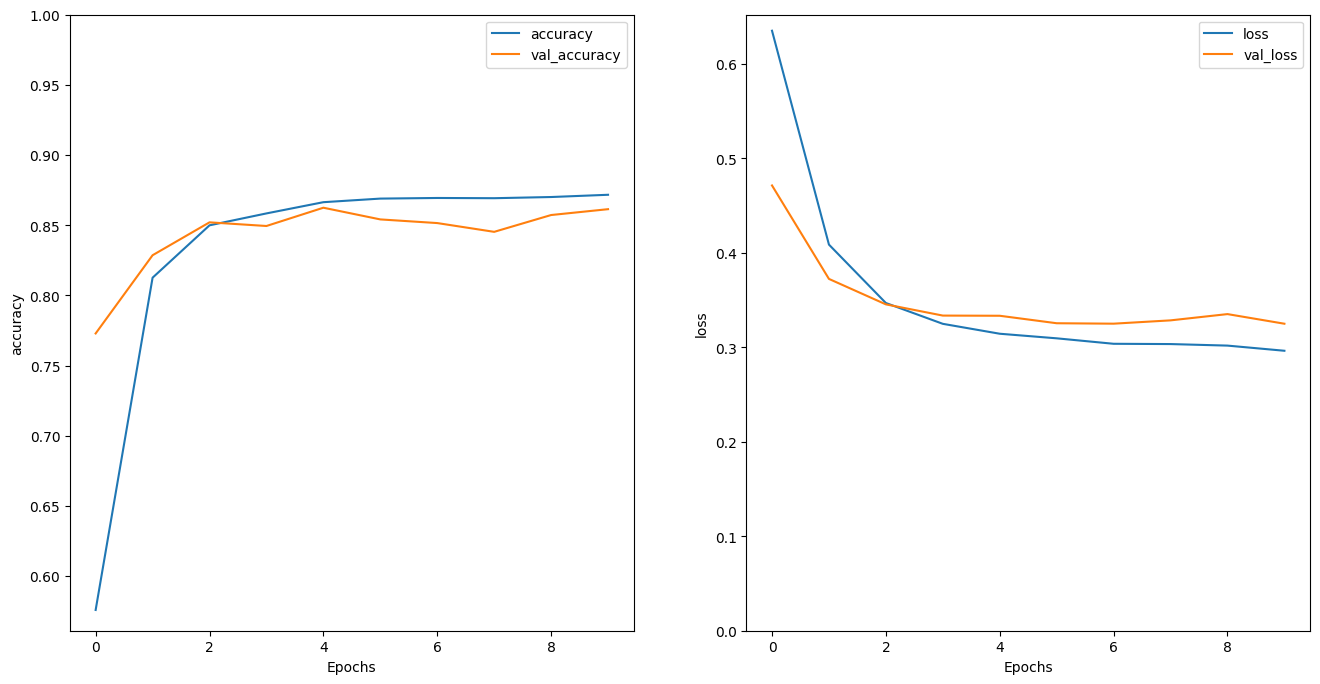

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [22]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1351s 3s/step - loss: 0.6205 - accuracy: 0.6001 - val_loss: 0.4184 - val_accuracy: 0.8250
Epoch 2/10
391/391 [==============================] - 1364s 3s/step - loss: 0.3773 - accuracy: 0.8375 - val_loss: 0.3515 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 1323s 3s/step - loss: 0.3339 - accuracy: 0.8577 - val_loss: 0.3299 - val_accuracy: 0.8625
Epoch 4/10
391/391 [==============================] - 1331s 3s/step - loss: 0.3179 - accuracy: 0.8647 - val_loss: 0.3216 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 1329s 3s/step - loss: 0.3138 - accuracy: 0.8646 - val_loss: 0.3242 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 1332s 3s/step - loss: 0.3067 - accuracy: 0.8695 - val_loss: 0.3275 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 1339s 3s/step - loss: 0.3024 - accuracy: 0.8704 - val_loss: 0.3247 - val_accuracy:

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 309s 792ms/step - loss: 0.3150 - accuracy: 0.8593
Test Loss: 0.31500786542892456
Test Accuracy: 0.8593199849128723


In [30]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ''were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 67ms/step
[[-1.7121272]]


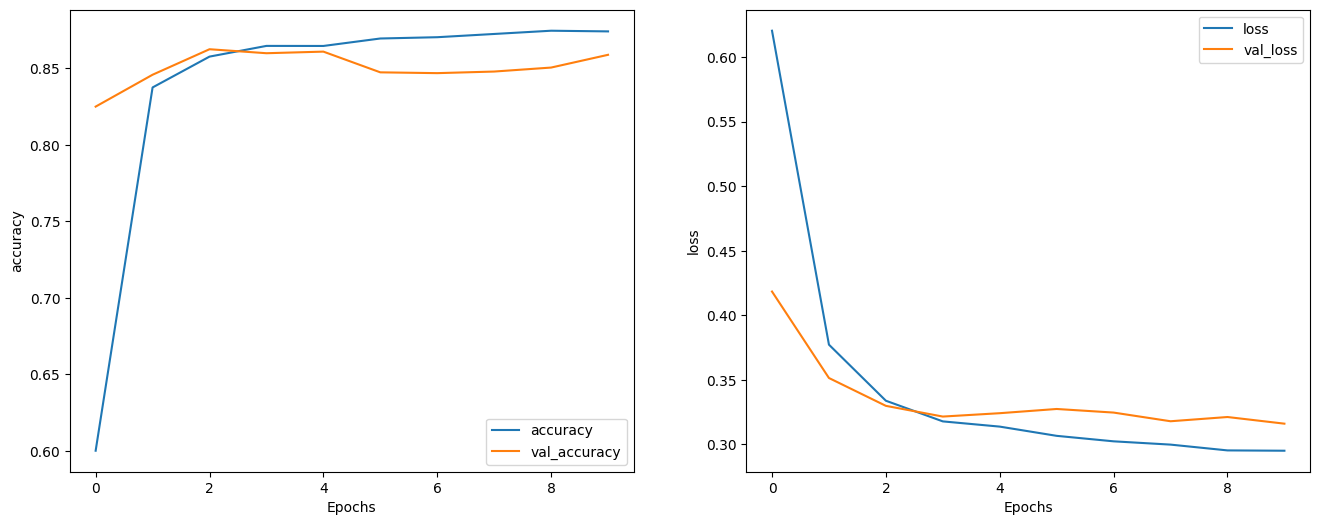

In [31]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')